스케일 처리된 파일 읽어오기 - scaled_by_skweness_and_kurtosis.csv

## 필수 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS



In [2]:
# CSV 파일 경로 설정
data_path = 'scaled_by_skweness_and_kurtosis.csv'

# 데이터 불러오기
df = pd.read_csv(data_path)

# 데이터의 처음 몇 행을 확인
print(df.head())


   Unnamed: 0  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0           0       1                   0            0             0   
1          26       1                   0            1             0   
2          40       1                   0            0             0   
3          42       1                   0            1             0   
4          81       1                   0            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                1           0.0             0.615   -0.198521    -0.011205   
1                1           0.0            -0.385    0.865982     0.120269   
2                1           0.0             0.615    1.262506     0.560259   
3                0           0.0            -0.135   -0.417076    -0.478337   
4                1           0.0            -0.735   -0.485530    -0.570468   

   ...  FONDKAPREMONT_MODE_org spec account  \
0  ...                                    0  

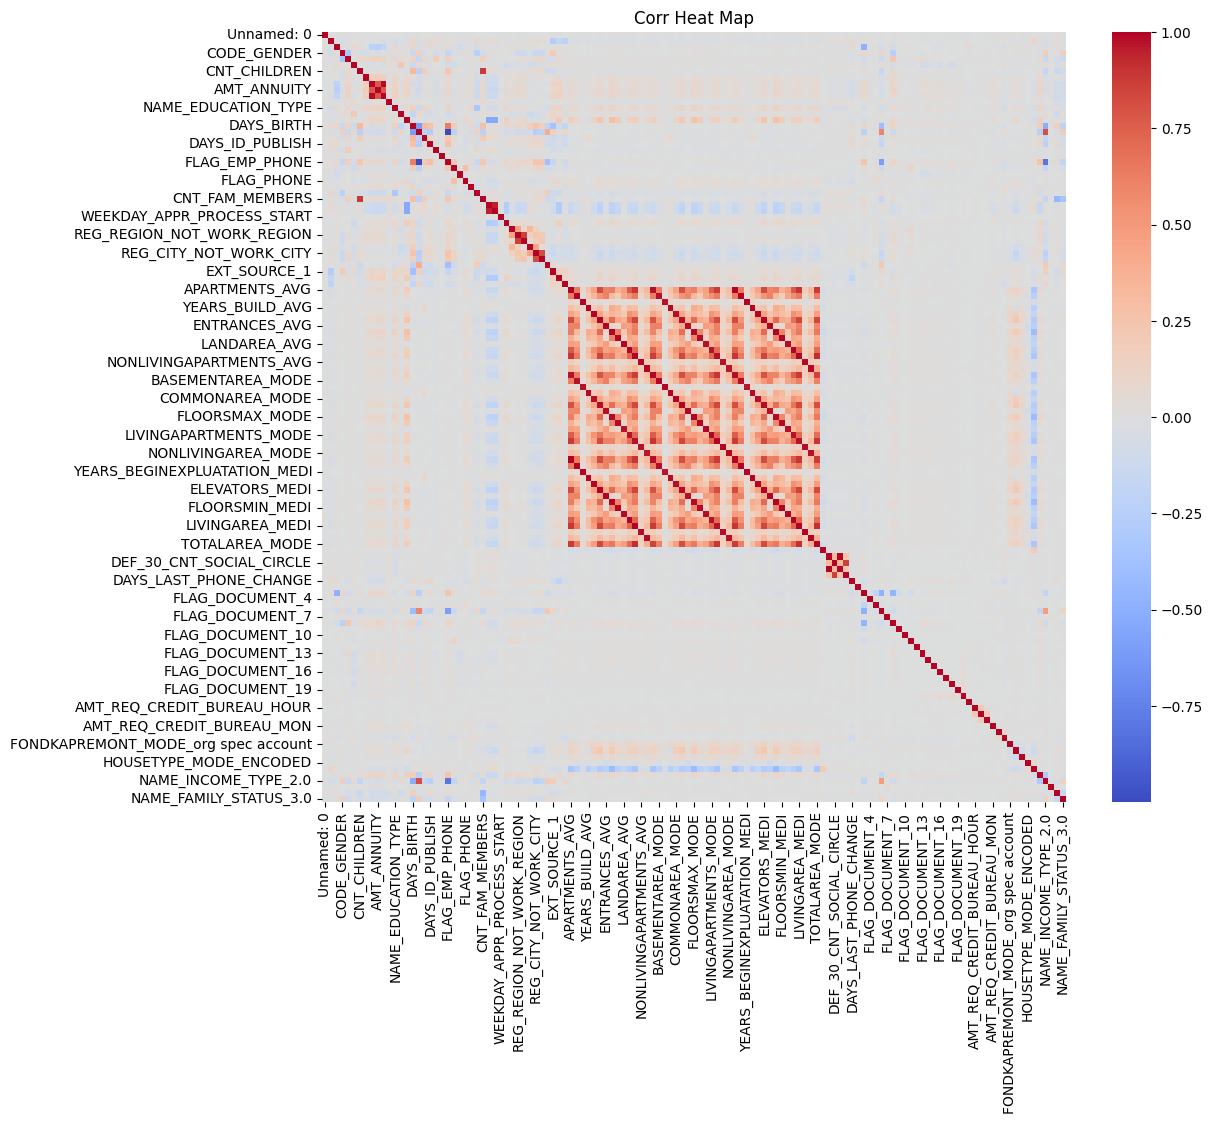

In [3]:
# corr 행렬 계산
corr_matrix = df.corr()
# corr 행렬 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Corr Heat Map')
plt.show()

In [4]:
# '_MEDI' 또는 '_AVG'로 끝나는 열을 삭제
columns_to_drop = [col for col in df.columns if col.endswith('_MEDI') or col.endswith('_AVG')]
df_drop_avg_medi = df.drop(columns=columns_to_drop)

# 결과 확인
print(f"삭제된 열: {columns_to_drop}")
print(f"새로운 데이터프레임 크기: {df_drop_avg_medi.shape}")
df_drop_avg_medi_data = df_drop_avg_medi.drop(columns="TARGET")

삭제된 열: ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI']
새로운 데이터프레임 크기: (307507, 99)


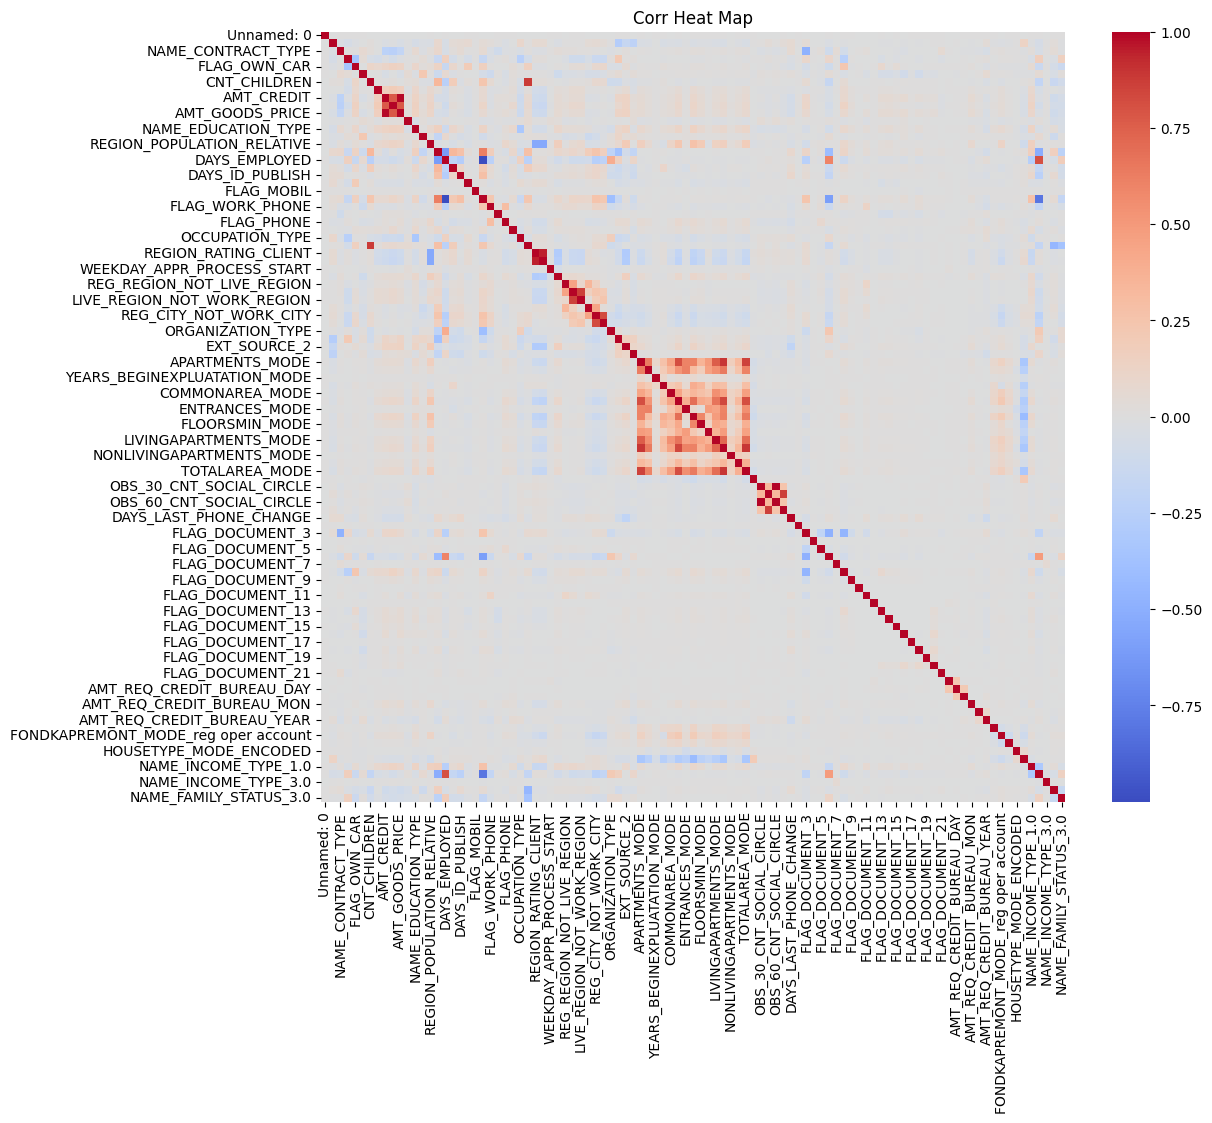

In [5]:
# corr 행렬 계산
corr_matrix = df_drop_avg_medi.corr()
# corr 행렬 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Corr Heat Map')
plt.show()

In [6]:
# 타겟 변수와 특성 분리
X = df_drop_avg_medi.drop('TARGET', axis=1)  # 'target'을 실제 타겟 변수 이름으로 변경
y = df_drop_avg_medi['TARGET']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)


In [12]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# 인덱스 확인
print(f"X_train index: {X_train.index}")
print(f"y_train index: {y_train.index}")

# 인덱스가 일치하지 않아서, 재설정
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_train shape: (246005, 98)
y_train shape: (246005,)
X_train index: Index([204118,  71550, 230283, 307046, 164472,  74753,  59944,  41748, 248778,
        96243,
       ...
       214251,  64395,  92913,  14527, 221002, 142142, 207999, 116985,   8899,
       208886],
      dtype='int64', length=246005)
y_train index: Index([204118,  71550, 230283, 307046, 164472,  74753,  59944,  41748, 248778,
        96243,
       ...
       214251,  64395,  92913,  14527, 221002, 142142, 207999, 116985,   8899,
       208886],
      dtype='int64', length=246005)


## Stepwise 커스텀 - 모델의 예측 성능의 임계값(0.001)을 넘지 못하면 stop

In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from itertools import combinations

def stepwise_selection(X, y, 
                       model, 
                       scoring='roc_auc', 
                       cv=5, 
                       threshold=1e-3, 
                       max_features=None, 
                       direction='forward'):
    """
    단계적 특징 선택 (Forward 또는 Backward) with Early Stopping

    Parameters:
    - X: 특징 데이터 (DataFrame)
    - y: 타겟 데이터 (Series 또는 ndarray)
    - model: 사용할 모델 (예: LogisticRegression)
    - scoring: 평가 지표 (기본: 'roc_auc')
    - cv: 교차 검증 폴드 수 (기본: 5)
    - threshold: 성능 향상 최소 기준 (기본: 1e-3)
    - max_features: 선택할 최대 특징 수 (기본: None, 모든 특징 사용)
    - direction: 'forward' 또는 'backward' (기본: 'forward')

    Returns:
    - selected_features: 선택된 특징 리스트
    - history: 선택 과정의 성능 기록
    """
    selected_features = []
    remaining_features = list(X.columns)
    best_score = 0
    history = []
    
    while True:
        scores_with_candidates = []
        if direction == 'forward':
            candidates = remaining_features
            for feature in candidates:
                current_features = selected_features + [feature]
                score = np.mean(cross_val_score(model, X[current_features], y, cv=cv, scoring=scoring, n_jobs=-1))
                scores_with_candidates.append((score, feature))
        elif direction == 'backward':
            if not selected_features:
                break
            candidates = selected_features
            for feature in candidates:
                current_features = selected_features.copy()
                current_features.remove(feature)
                score = np.mean(cross_val_score(model, X[current_features], y, cv=cv, scoring=scoring, n_jobs=-1))
                scores_with_candidates.append((score, feature))
        else:
            raise ValueError("direction는 'forward' 또는 'backward' 이어야 합니다.")
        
        if not scores_with_candidates:
            break
        
        # 최고 성능과 해당 특징 찾기
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates[0]
        
        improvement = best_new_score - best_score
        if improvement > threshold:
            selected_features.append(best_candidate) if direction == 'forward' else selected_features.remove(best_candidate)
            remaining_features.remove(best_candidate) if direction == 'forward' else remaining_features.append(best_candidate)
            best_score = best_new_score
            history.append((selected_features.copy(), best_score))
            print(f"특징: {best_candidate}, 향상된 점수: {improvement:.6f}, 현재 점수: {best_score:.6f}")
            if max_features and len(selected_features) >= max_features:
                print("최대 특징 수에 도달하여 중단합니다.")
                break
        else:
            print("성능 향상이 threshold 이하이므로 선택 과정을 중단합니다.")
            break
    
    return selected_features, history

# 로지스틱 회귀 모델 초기화
logreg = LogisticRegression(
    penalty='none',  # 정규화 사용 안함
    solver='lbfgs', 
    max_iter=1000, 
    random_state=42
)

# 단계적 특징 선택 수행 (Forward Selection 예시)
selected_features, history = stepwise_selection(
    X_train, 
    y_train, 
    model=logreg, 
    scoring='roc_auc', 
    cv=2, 
    threshold=1e-3,  # 최소 향상 기준
    max_features=None,  # 최대 특징 수 제한 없음
    direction='forward'  # 'forward' 또는 'backward' 선택
)

print(f"선택된 특성 개수: {len(selected_features)}")
print("선택된 특성들:", selected_features)


특징: EXT_SOURCE_1, 향상된 점수: 0.807590, 현재 점수: 0.807590
특징: EXT_SOURCE_3, 향상된 점수: 0.020591, 현재 점수: 0.828180
특징: WALLSMATERIAL_MODE_ENCODED, 향상된 점수: 0.010239, 현재 점수: 0.838419
특징: EXT_SOURCE_2, 향상된 점수: 0.005984, 현재 점수: 0.844403
특징: OWN_CAR_AGE, 향상된 점수: 0.002138, 현재 점수: 0.846541
특징: DAYS_BIRTH, 향상된 점수: 0.001889, 현재 점수: 0.848430
특징: OCCUPATION_TYPE, 향상된 점수: 0.001102, 현재 점수: 0.849532
특징: FLAG_EMP_PHONE, 향상된 점수: 0.001082, 현재 점수: 0.850615
성능 향상이 threshold 이하이므로 선택 과정을 중단합니다.
선택된 특성 개수: 8
선택된 특성들: ['EXT_SOURCE_1', 'EXT_SOURCE_3', 'WALLSMATERIAL_MODE_ENCODED', 'EXT_SOURCE_2', 'OWN_CAR_AGE', 'DAYS_BIRTH', 'OCCUPATION_TYPE', 'FLAG_EMP_PHONE']


In [46]:
## ['EXT_SOURCE_1', 'EXT_SOURCE_3', 'WALLSMATERIAL_MODE_ENCODED', 'EXT_SOURCE_2', 'OWN_CAR_AGE', 'DAYS_BIRTH', 'OCCUPATION_TYPE', 'FLAG_EMP_PHONE']

In [15]:
# 선택된 특성을 사용하여 훈련 및 테스트 데이터 재구성
X_train = X_train[selected_features]
X_test = X_test[selected_features]

print("선택된 특성을 사용한 훈련 데이터 크기:", X_train.shape)
print("선택된 특성을 사용한 테스트 데이터 크기:", X_test.shape)


선택된 특성을 사용한 훈련 데이터 크기: (246005, 8)
선택된 특성을 사용한 테스트 데이터 크기: (61502, 8)


In [16]:
# SMOTE 미적용 로지스틱 회귀 모델 초기화 (L1 정규화)
logreg = LogisticRegression(penalty='l1', 
                            solver='liblinear', 
                            C=1.0, 
                            class_weight='balanced', 
                            random_state=42,
                            max_iter=1000)

# 모델 학습
logreg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [17]:
# 예측 수행
y_pred = logreg.predict(X_test)


In [18]:
# 평가 지표 출력
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))


Confusion Matrix:
[[45075 11462]
 [ 1014  3951]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     56537
           1       0.26      0.80      0.39      4965

    accuracy                           0.80     61502
   macro avg       0.62      0.80      0.63     61502
weighted avg       0.92      0.80      0.84     61502

Accuracy: 0.7971448082989171


c:\Users\JSH\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\JSH\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\JSH\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


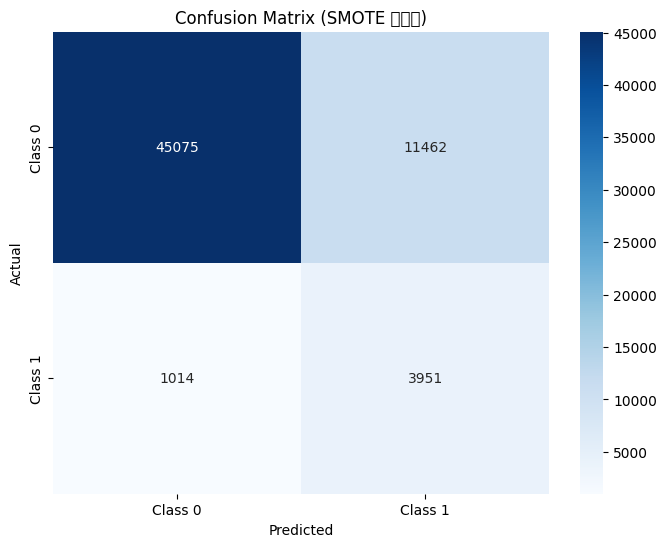

In [19]:
# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix (SMOTE 미적용)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


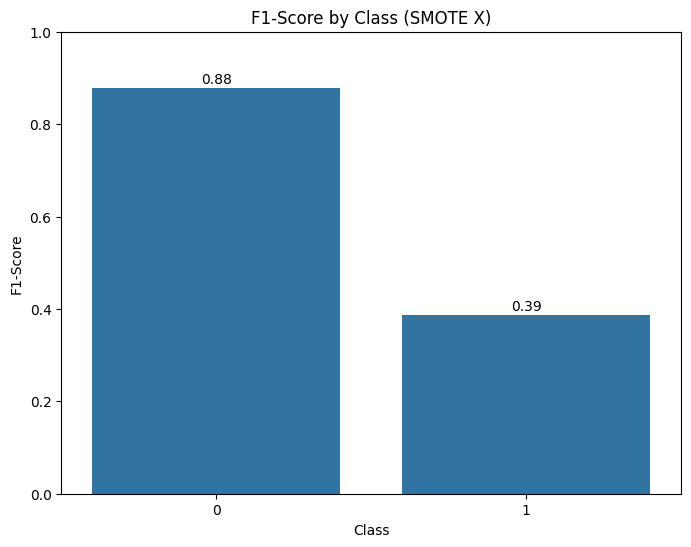

In [47]:
# 분류 보고서 시각화 (Precision, Recall, F1-Score)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:-3, :]  # 전체 클래스만 선택

plt.figure(figsize=(8, 6))
sns.barplot(x=report_df.index, y='f1-score', data=report_df)
plt.title("F1-Score by Class (SMOTE X)")
plt.xlabel("Class")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
for index, value in enumerate(report_df['f1-score']):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center')
plt.show()


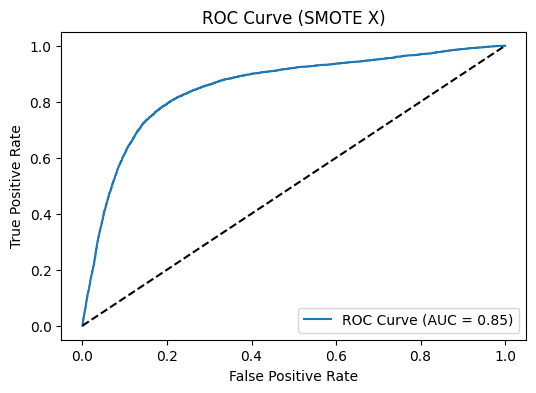

ROC AUC Score: 0.8514


In [48]:
# ROC 커브 시각화
y_proba = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (SMOTE X)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


In [23]:
# 그리드 서치 파라미터 정의
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],  # 'saga'는 'l1'과 'l2' 모두 지원
}

# 그리드 서치 초기화
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
                           param_grid, 
                           cv=5, 
                           scoring='roc_auc', 
                           n_jobs=-1, 
                           verbose=1)

# 그리드 서치 수행
grid_search.fit(X_train, y_train)

print(f"\n최적 파라미터 (SMOTE 미적용): {grid_search.best_params_}")
print(f"최고 교차 검증 ROC AUC 점수: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits

최적 파라미터 (SMOTE 미적용): {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
최고 교차 검증 ROC AUC 점수: 0.8528


In [24]:
# 최적 모델을 사용하여 테스트 데이터 예측
best_logreg = grid_search.best_estimator_
y_pred_best = best_logreg.predict(X_test)
y_proba_best = best_logreg.predict_proba(X_test)[:, 1]

# 평가 지표 출력
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_proba_best)
print(f"Accuracy: {accuracy_best:.4f}")
print(f"ROC AUC Score: {roc_auc_best:.4f}")



Confusion Matrix:
[[45083 11454]
 [ 1015  3950]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     56537
           1       0.26      0.80      0.39      4965

    accuracy                           0.80     61502
   macro avg       0.62      0.80      0.63     61502
weighted avg       0.92      0.80      0.84     61502

Accuracy: 0.7973
ROC AUC Score: 0.8514


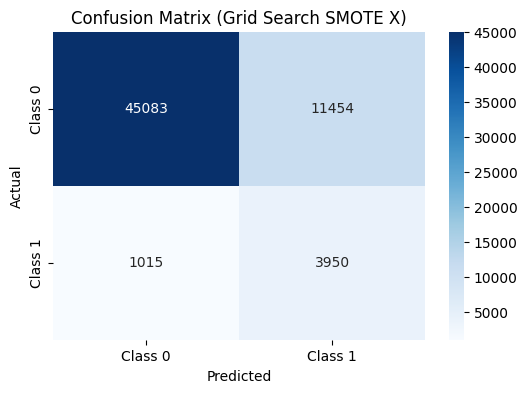

In [49]:
# 혼동 행렬 시각화
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix (Grid Search SMOTE X)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


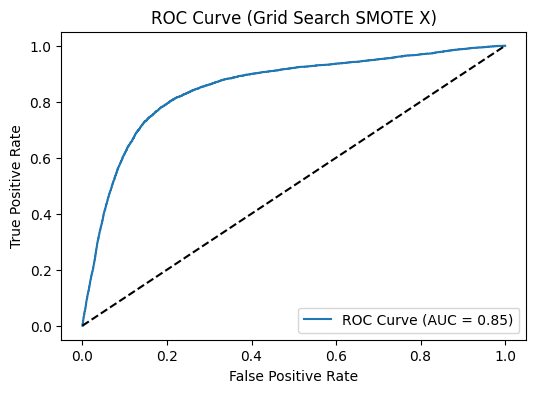

In [50]:
# ROC 커브 시각화
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_proba_best)
plt.figure(figsize=(6, 4))
plt.plot(fpr_best, tpr_best, label=f'ROC Curve (AUC = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Grid Search SMOTE X)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()


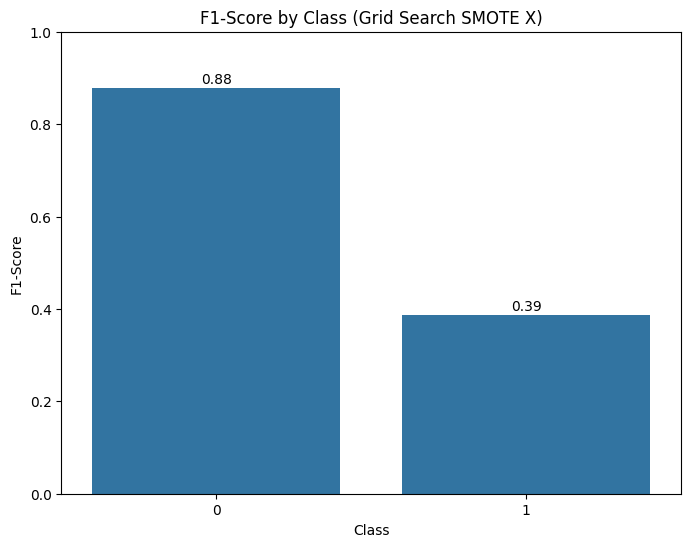

In [51]:
# F1-Score 시각화
report_best = classification_report(y_test, y_pred_best, output_dict=True)
report_df_best = pd.DataFrame(report_best).transpose().iloc[:-3, :]  # 전체 클래스만 선택

plt.figure(figsize=(8, 6))
sns.barplot(x=report_df_best.index, y='f1-score', data=report_df_best)
plt.title("F1-Score by Class (Grid Search SMOTE X)")
plt.xlabel("Class")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
for index, value in enumerate(report_df_best['f1-score']):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center')
plt.show()


In [29]:
# SMOTE 적용하여 데이터 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("SMOTE 적용 완료. 클래스 분포:")
print(y_train_smote.value_counts())


SMOTE 적용 완료. 클래스 분포:
TARGET
0    226145
1    226145
Name: count, dtype: int64


In [30]:
# SMOTE 적용 로지스틱 회귀 모델 초기화 (L1 정규화)
logreg_smote = LogisticRegression(penalty='l1', 
                                  solver='liblinear', 
                                  C=1.0, 
                                  class_weight='balanced', 
                                  random_state=42,
                                  max_iter=1000)

# 모델 학습
logreg_smote.fit(X_train_smote, y_train_smote)


LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [31]:
# 예측 수행
y_pred_smote = logreg_smote.predict(X_test)


In [32]:
# 평가 지표 출력
print("Confusion Matrix (SMOTE 적용):")
print(confusion_matrix(y_test, y_pred_smote))

print("\nClassification Report (SMOTE 적용):")
print(classification_report(y_test, y_pred_smote))

print("Accuracy (SMOTE 적용):", accuracy_score(y_test, y_pred_smote))


Confusion Matrix (SMOTE 적용):
[[45177 11360]
 [ 1024  3941]]

Classification Report (SMOTE 적용):
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     56537
           1       0.26      0.79      0.39      4965

    accuracy                           0.80     61502
   macro avg       0.62      0.80      0.63     61502
weighted avg       0.92      0.80      0.84     61502

Accuracy (SMOTE 적용): 0.7986406946115574


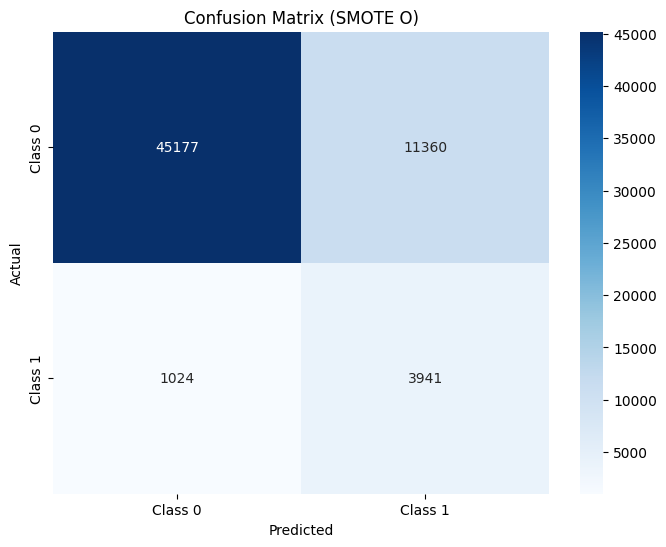

In [52]:
# 혼동 행렬 시각화
cm_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_smote, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix (SMOTE O)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


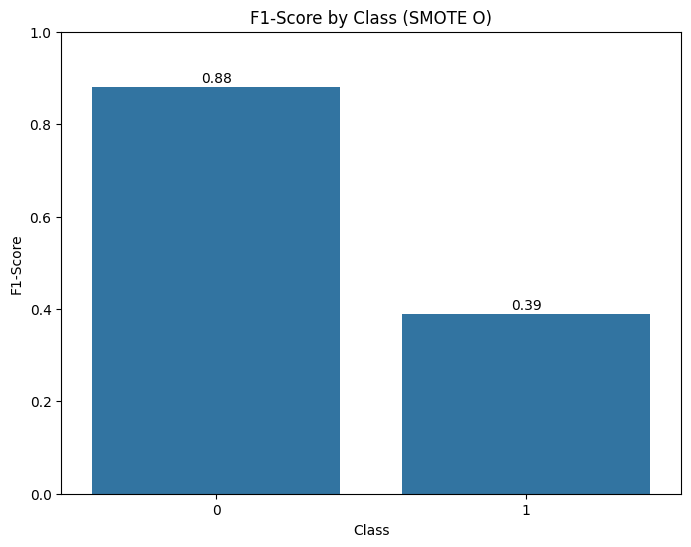

In [53]:
# 분류 보고서 시각화 (Precision, Recall, F1-Score)
report_smote = classification_report(y_test, y_pred_smote, output_dict=True)
report_df_smote = pd.DataFrame(report_smote).transpose().iloc[:-3, :]  # 전체 클래스만 선택

plt.figure(figsize=(8, 6))
sns.barplot(x=report_df_smote.index, y='f1-score', data=report_df_smote)
plt.title("F1-Score by Class (SMOTE O)")
plt.xlabel("Class")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
for index, value in enumerate(report_df_smote['f1-score']):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center')
plt.show()


c:\Users\JSH\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\JSH\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


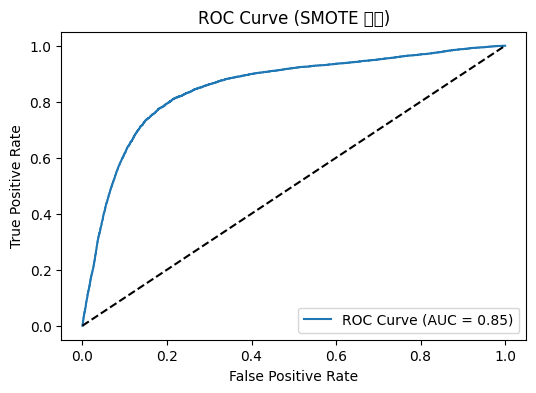

ROC AUC Score (SMOTE O): 0.8514


In [54]:
# ROC 커브 시각화
y_proba_smote = logreg_smote.predict_proba(X_test)[:, 1]
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_proba_smote)
roc_auc_smote = roc_auc_score(y_test, y_proba_smote)

plt.figure(figsize=(6, 4))
plt.plot(fpr_smote, tpr_smote, label=f'ROC Curve (AUC = {roc_auc_smote:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (SMOTE 적용)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score (SMOTE O): {roc_auc_smote:.4f}")


In [55]:
# 그리드 서치 파라미터 정의
param_grid_smote = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],  # 'saga'는 'l1'과 'l2' 모두 지원
}

# 그리드 서치 초기화
grid_search_smote = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
                                 param_grid_smote, 
                                 cv=5, 
                                 scoring='roc_auc', 
                                 n_jobs=-1, 
                                 verbose=1)

# 그리드 서치 수행
grid_search_smote.fit(X_train_smote, y_train_smote)

print(f"\n최적 파라미터 (SMOTE 적용): {grid_search_smote.best_params_}")
print(f"최고 교차 검증 ROC AUC 점수: {grid_search_smote.best_score_:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits

최적 파라미터 (SMOTE 적용): {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
최고 교차 검증 ROC AUC 점수: 0.8563


In [56]:
# 최적 모델을 사용하여 테스트 데이터에 대한 예측 수행
y_pred_smote_best = grid_search_smote.best_estimator_.predict(X_test)

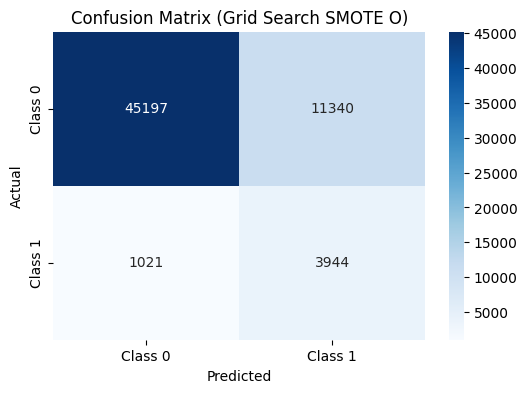

In [57]:
# 혼동 행렬 시각화
cm_smote_best = confusion_matrix(y_test, y_pred_smote_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_smote_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix (Grid Search SMOTE O)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


c:\Users\JSH\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\JSH\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


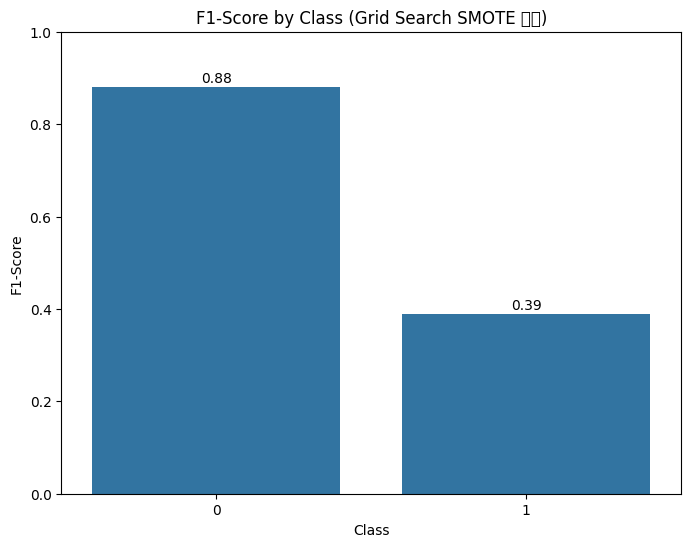

In [58]:
# F1-Score 시각화
report_smote_best = classification_report(y_test, y_pred_smote_best, output_dict=True)
report_df_smote_best = pd.DataFrame(report_smote_best).transpose().iloc[:-3, :]  # 전체 클래스만 선택

plt.figure(figsize=(8, 6))
sns.barplot(x=report_df_smote_best.index, y='f1-score', data=report_df_smote_best)
plt.title("F1-Score by Class (Grid Search SMOTE 적용)")
plt.xlabel("Class")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
for index, value in enumerate(report_df_smote_best['f1-score']):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center')
plt.show()
